# Advanced Lane Finding


### Import required library

In [1]:
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from collections import deque
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
print('Done')

Done


### Step 1: Calibrate Camera

The first step is to calibrate camera using chessborad corners images. Calibration images stored in 'camera_cal' folder. The output of the process stored on 'output_images' folder. Objpoints and imgpoints needed for camera calibration.

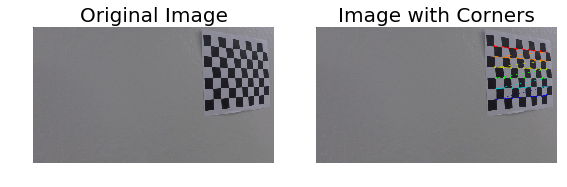

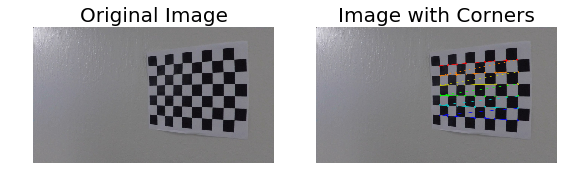

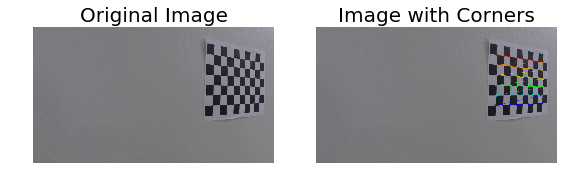

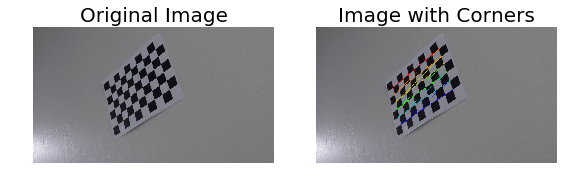

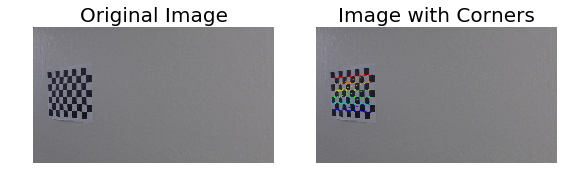

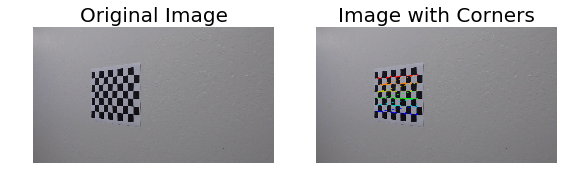

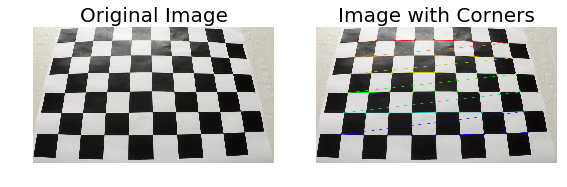

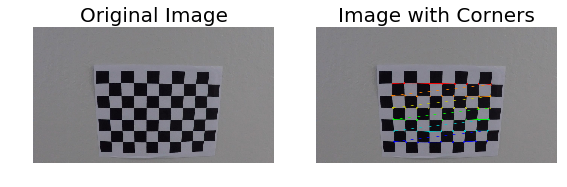

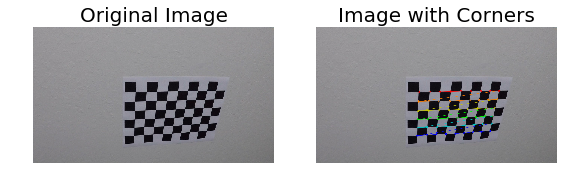

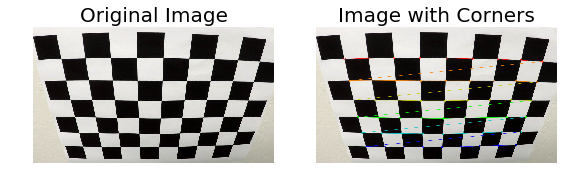

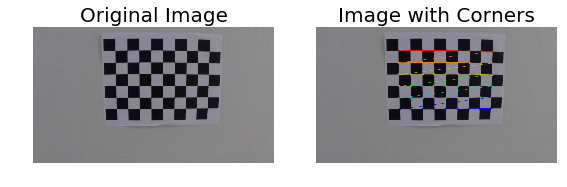

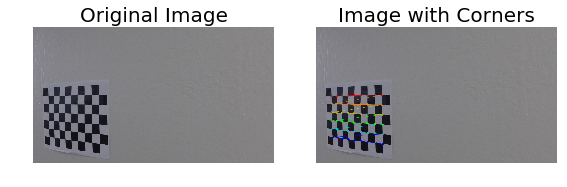

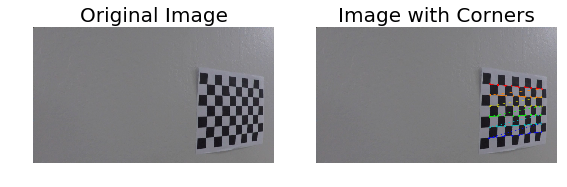

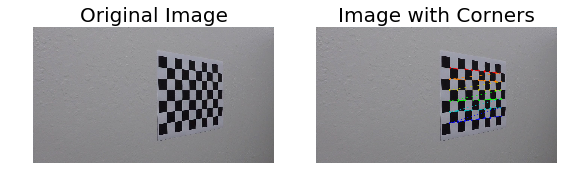

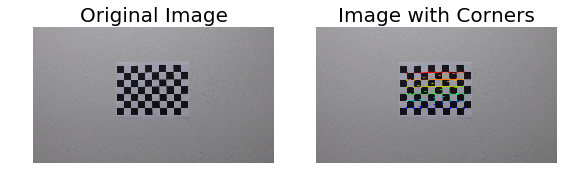

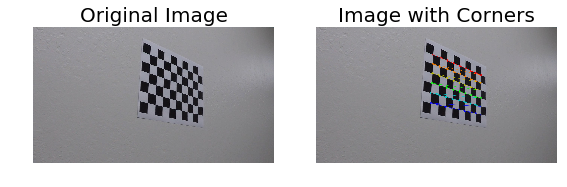

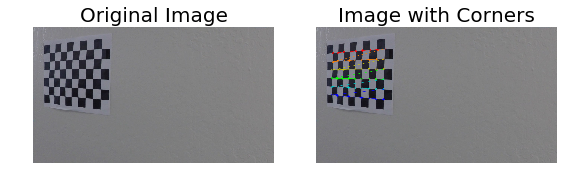

In [2]:
#Images calibration directory
cal_dir='camera_cal/'

#Initialize xyz chessboard 6 row by 9 columns inside corner
objp = np.zeros((6*9,3), np.float32)

#Generate coordinate x,y  
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) 

objpoints = [] # object point in real world space
imgpoints = [] # image point in image plane.

# Termination and second corner criteria to increase accuracy. Adopted from openCV tutorial
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/
# py_calibration/py_calibration.html

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

images = glob.glob(cal_dir + 'calibration*.jpg')

for index, filename in enumerate(images):
 
    #open CV read in BGR
    process_image = cv2.imread(filename)
    gray = cv2.cvtColor(process_image, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
  
        # increase accuracy with corner2
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        
        # If corner (ret=True) found, append object points, image points on array
        objpoints.append(objp)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        corner_image=cv2.drawChessboardCorners(process_image, (9,6), corners2, ret)
        
        fixed, (axis1, axis2) = plt.subplots(1, 2, figsize=(8,4),squeeze=True)
        fixed.tight_layout()
        
        # Vizualise images in RGB 
        axis1.imshow(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))
        axis1.axis('off')
        axis1.set_title('Original Image', fontsize=20)
        
        # Vizualise images in RGB 
        axis2.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
        axis2.axis('off')
        axis2.set_title('Image with Corners',fontsize=20)
        plt.savefig('output_images/calibration/' + filename)

(-0.5, 1279.5, 719.5, -0.5)

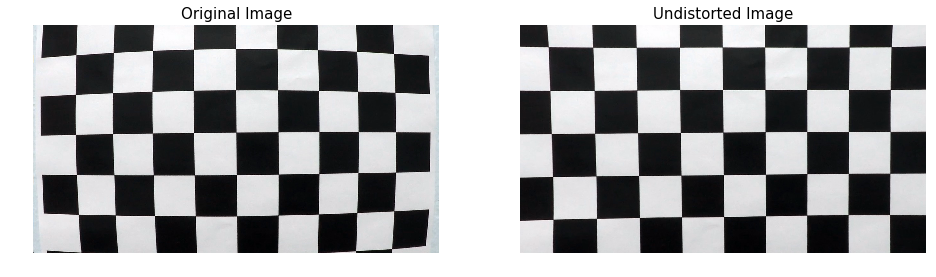

In [3]:
# Test Camera calibration sample
imgread = cv2.imread('camera_cal/calibration1.jpg')  
    
img_shape = (imgread.shape[1], imgread.shape[0])
ret, mtrix, distcoef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
undist = cv2.undistort(imgread, mtrix, distcoef, None, mtrix)
    
#initialize save holder for camera calibration.
caldict = {'mtrix': mtrix, 'distcoef': distcoef}
with open('cal_camera.p', 'wb') as f:
    pickle.dump(caldict, f)
    
fixed, (axis1, axis2) = plt.subplots(1, 2, figsize=(16,10),squeeze=True,sharex='col')
axis1.imshow(imgread)
axis1.axis('off')
axis1.set_title('Original Image', fontsize=15)
axis2.imshow(undist)
axis2.set_title('Undistorted Image', fontsize=15)
axis2.axis('off')

### Step 2: Camera Distortion Correction
The second step is calculating distortion correction base on value generated from chessboard camera calibration. This step using provided test images on folder 'test_images' and output stored in 'output images' folder. Save camera calibration matrix and distortion coefficient in file 'cal_camera.p'.

In [4]:
# Remove distortion from images
def undistort(image, videoprocess=False):
    
    imgread=image 
    if videoprocess==False:
         imgread = cv2.imread(image)    
    #undist function
    undist = cv2.undistort(imgread, mtrix, distcoef, None, mtrix)
    
    return undist

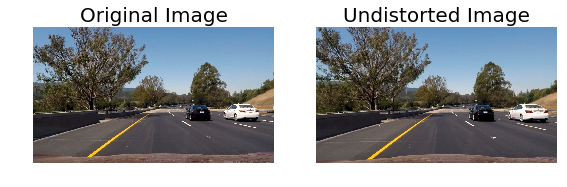

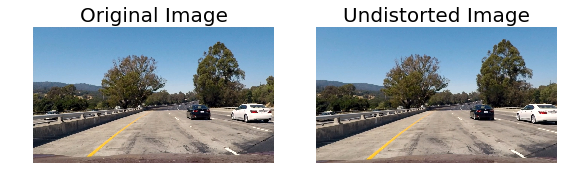

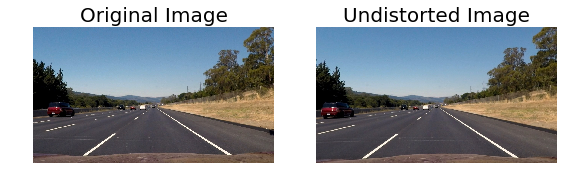

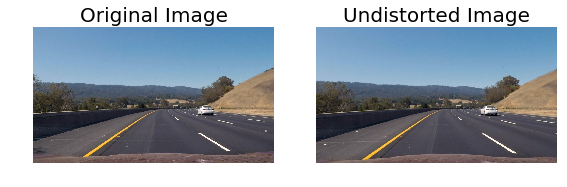

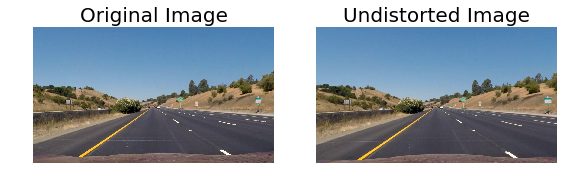

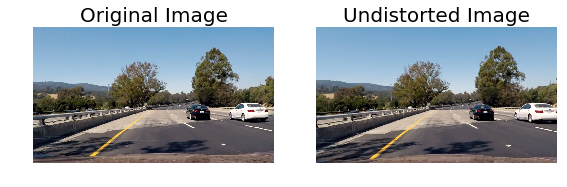

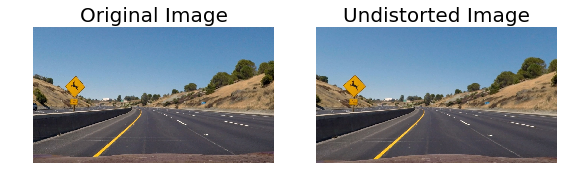

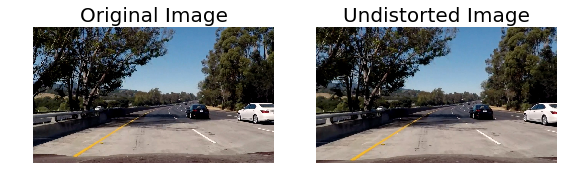

In [5]:
#Vizualised Undistort Test Images
images = glob.glob('test_images/*.jpg')

for image in images:
    
    #open CV read in BGR
    #img = cv2.imread(image)
    #Show images in RGB Format and save output images in 'output_images' directory
    
    fixed, (axis1, axis2) = plt.subplots(1, 2, figsize=(8,4),squeeze=True,sharex='col')
    fixed.tight_layout()
    axis1.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    axis1.axis('off')
    axis1.set_title('Original Image', fontsize=20)
    axis2.imshow(cv2.cvtColor( undistort(image), cv2.COLOR_BGR2RGB))
    axis2.set_title('Undistorted Image', fontsize=20)
    axis2.axis('off')
    plt.savefig('output_images/undistort/' + image)

### Step 3: Perspective Transform

In [6]:
#Devine Image transformation coordinate. Source and Destination Image Windows
#Source Image
#sourceimg = np.float32([[520, 495],[800, 495],
#                     [153, 720],[1200, 720]])
#Destination Image
#destimg = np.float32([[40, 0], [1250, 0], 
#                [40, 720], [1250, 720]])   

#Ver 1
#sourceimg = np.float32([[520, 495],[800, 495],[153, 720],[1200, 720]])
#destimg = np.float32([[40, 0], [1250, 0],[40, 720], [1250, 720]])

#Source Image
sourceimg = np.float32([[555, 465],[760, 465],[130, 720],[1205, 720]])
#Destination Image
destimg = np.float32([[40, 0], [1250, 0], [40, 720], [1250, 720]])   


In [7]:
# Perform perspective transform
def birdseyeview(img):
    undist = undistort(img)
    img_size = (undist.shape[1], undist.shape[0])
    M = cv2.getPerspectiveTransform(sourceimg, destimg)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

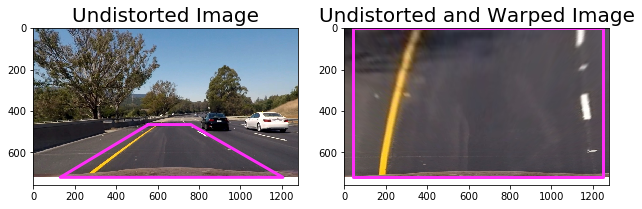

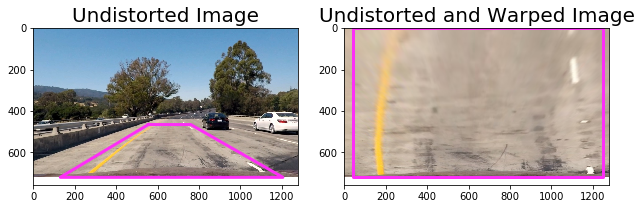

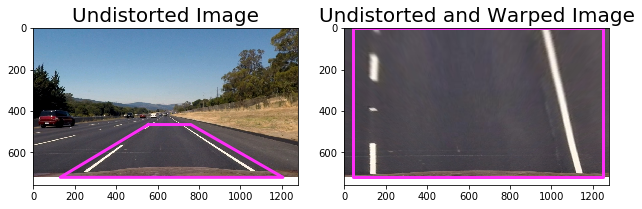

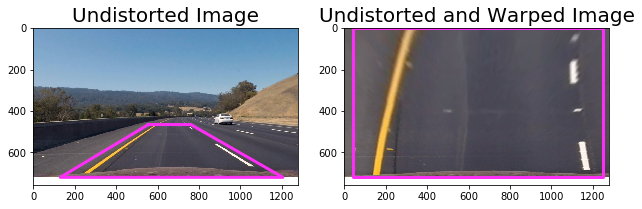

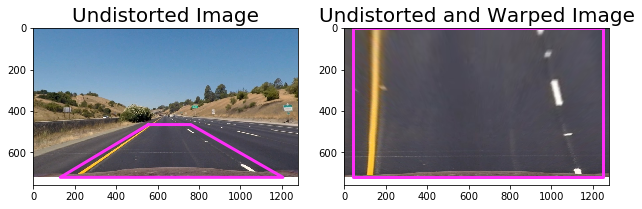

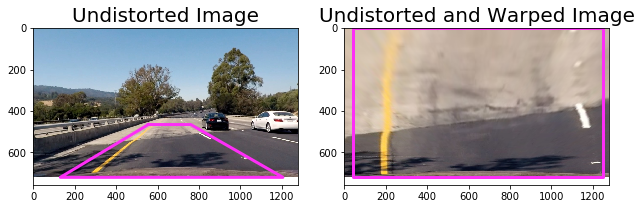

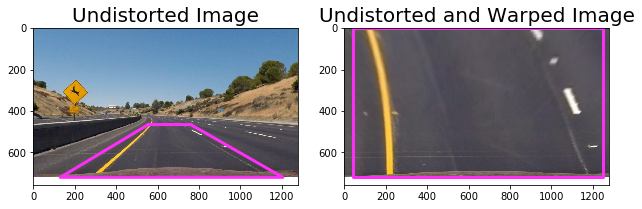

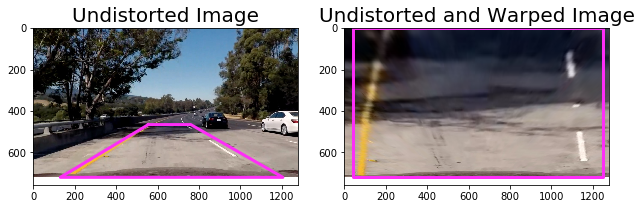

In [8]:
# Vizualised Undistorted Image and Warped Image
for image in glob.glob('test_images/*.jpg'):
    #birds_eye(image)
    byeimage, M = birdseyeview(image)
    
    fixed, (axis1, axis2) = plt.subplots(1, 2, figsize=(8,4),squeeze=True,sharex='col')
    fixed.tight_layout()
    
    #Plot Undistored Image
    axis1.imshow(cv2.cvtColor(undistort(image), cv2.COLOR_BGR2RGB))
    axis1.set_title('Undistorted Image', fontsize=20)
    
    #Plot Trapezoid of interest on image
    x = [sourceimg[0][0],sourceimg[2][0],sourceimg[3][0],sourceimg[1][0],sourceimg[0][0]]
    y = [sourceimg[0][1],sourceimg[2][1],sourceimg[3][1],sourceimg[1][1],sourceimg[0][1]]
    axis1.plot(x, y, color='#FE2EF7', linewidth=3)
    
    #undistorgimage = cv2.cvtColor(byeimage, cv2.COLOR_BGR2RGB)
    #Plot Trapezoid area of interest on image
    x2 = [destimg[0][0],destimg[2][0],destimg[3][0],destimg[1][0],destimg[0][0]]
    y2 = [destimg[0][1],destimg[2][1],destimg[3][1],destimg[1][1],destimg[0][1]]
 
    #Plot warped image
    axis2.imshow(cv2.cvtColor(byeimage, cv2.COLOR_BGR2RGB))
    axis2.plot(x2, y2, color='#FE2EF7', linewidth=3)
    #axis2.axis('off')
    axis2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.savefig('output_images/warped/' + image)

### Step 4: Apply Binary Color Thresholds.

In [9]:
# Color threshold function 
def colospace_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    #b channel threshold
    if orient=='b':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]  
    
    #b channel threshold. RGB input
    elif orient=='brgb': 
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    
    #h channel threshold
    elif orient=='h':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,0]
    
    #l channel threshold
    elif orient=='l':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,1]
    
    #l channel threshold. RGB input
    elif orient=='lrgb':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0] 
    
    #s channel threshold
    elif orient=='s':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    #u channel threshold
    elif orient=='u':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,1]
    
    #v channel threshold
    elif orient=='v':        
        colospace_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,2]
    
    #Gray x sobel threshold
    elif orient=='x':
        greyscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        abs_sobel = np.absolute(cv2.Sobel(greyscale, cv2.CV_64F, 1, 0,ksize=7)) #ksize is sobel kernel size
        colospace_channel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Gray y sobel threshold
    elif orient=='y':
        greyscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        abs_sobel = np.absolute(cv2.Sobel(greyscale, cv2.CV_64F, 0, 1,ksize=7)) #ksize is sobel kernel size
        colospace_channel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    else:
        return
    
    output_binary = np.zeros_like(colospace_channel)
    output_binary[(colospace_channel >= thresh_min) & (colospace_channel <= thresh_max)] = 1
    #l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    return output_binary

After vizualisation of images. It looks like b color space is more superior in detecting yellow line and l color space is good in detecting white line. I used combination or both b and l color space via OR ("|") operator in this process.

In [10]:
# Create binary thresholded images to isolate lane line pixels
def combine_color_binary(image, visualize=True):
    
    img, M = birdseyeview(image)
    
    x_colospace_thresh = colospace_thresh(img, orient='x', thresh_min=45, thresh_max=50)
    y_colospace_thresh = colospace_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    s_binary = colospace_thresh(img, orient='s', thresh_min=110, thresh_max=255)
    b_binary = colospace_thresh(img, orient='b', thresh_min=147, thresh_max=200) #170 200 148
    l_binary = colospace_thresh(img, orient='l', thresh_min=217, thresh_max=255) #207
    h_binary = colospace_thresh(img, orient='h', thresh_min=150, thresh_max=255)

    #color_binary = np.dstack((u_binary, s_binary, l_binary))   
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1)| (b_binary == 1)] = 1
  
    
    if visualize==False:
          return combined_binary
    else :
        
        # Plotting thresholded images
        fixed, ((axis1, axis2, axis3), (axis4, axis5, axis6), (axis7, axis8, axis9) ) = \
         plt.subplots(3, 3, squeeze=False, sharey='col', sharex='row',figsize=(18,8))

        fixed.tight_layout()
        axis1.set_title('Original Image', fontsize=16)
        axis1.imshow(cv2.cvtColor(undistort(image),cv2.COLOR_BGR2RGB))
        axis1.axis('off')

        axis2.set_title('BirdEye View Image', fontsize=16)
        axis2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        axis2.axis('off')

        axis3.set_title('S binary threshold', fontsize=16)
        axis3.imshow(s_binary, cmap='gray')
        axis3.axis('off')

        axis4.set_title('B binary threshold', fontsize=16)
        axis4.imshow(b_binary, cmap='gray')
        axis4.axis('off')

        axis5.set_title('L binary threshold', fontsize=16)
        axis5.imshow(l_binary, cmap='gray')
        axis5.axis('off')

        axis6.set_title('X-Sobel', fontsize=16)
        axis6.imshow(x_colospace_thresh, cmap='gray')
        axis6.axis('off')
        
        axis7.set_title('Y-Sobel', fontsize=16)
        axis7.imshow(y_colospace_thresh, cmap='gray')
        axis7.axis('off')

        axis8.set_title('h binary threshold', fontsize=16)
        axis8.imshow(h_binary, cmap='gray')
        axis8.axis('off')

        axis9.set_title('Combined color thresholds', fontsize=16)
        axis9.imshow(combined_binary, cmap='gray')
        axis9.axis('off')

        plt.savefig('output_images/combine/' + image)

  

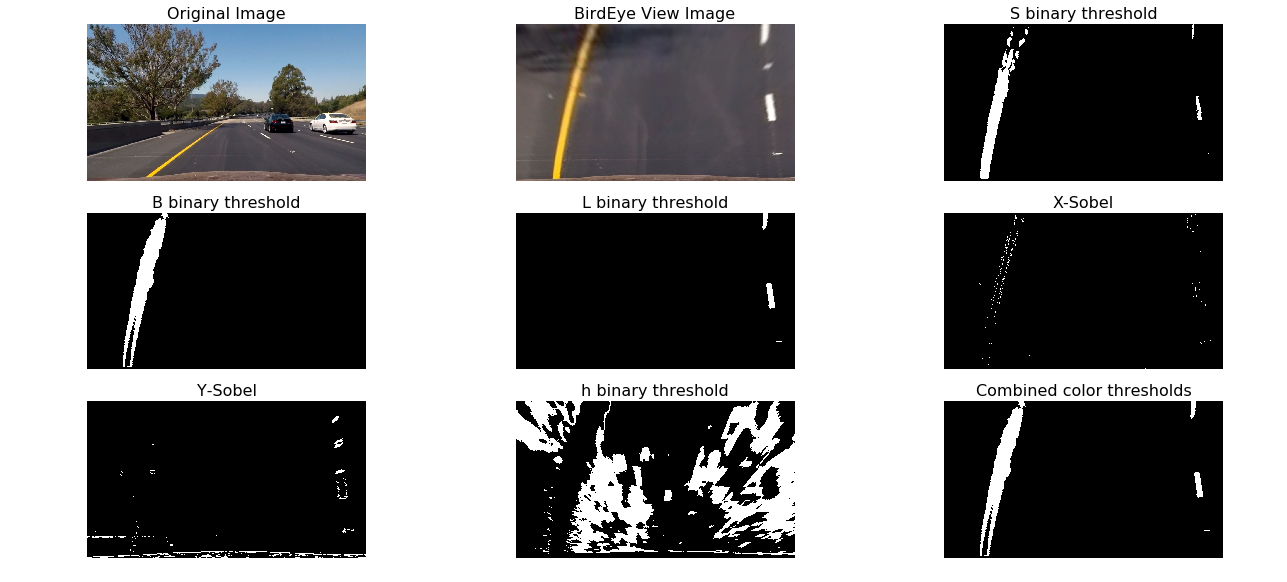

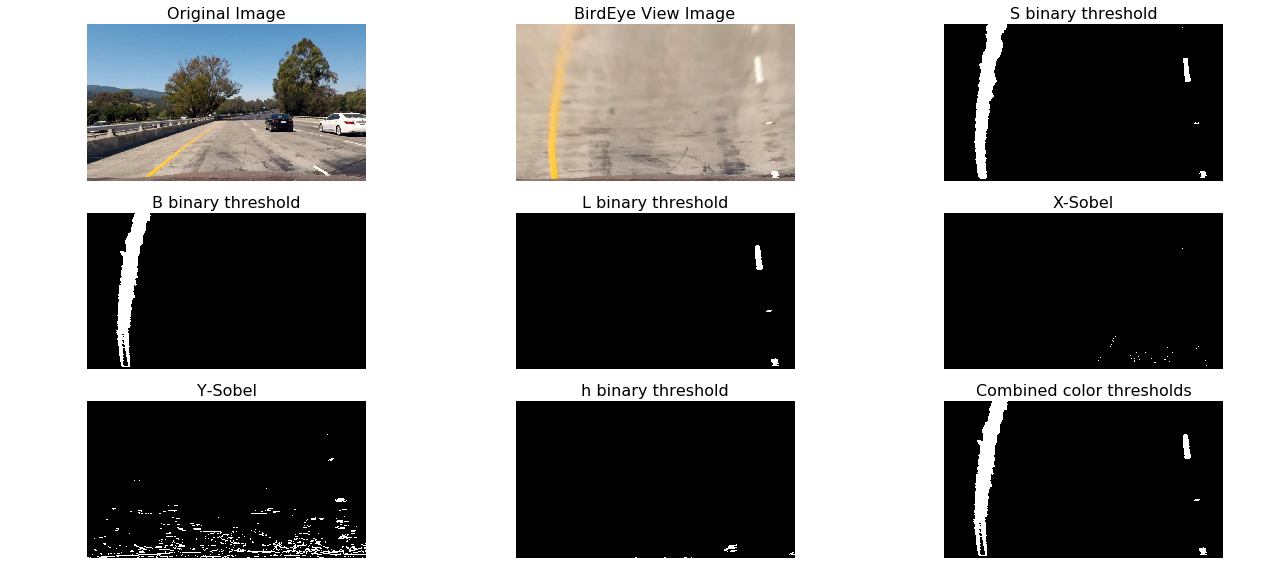

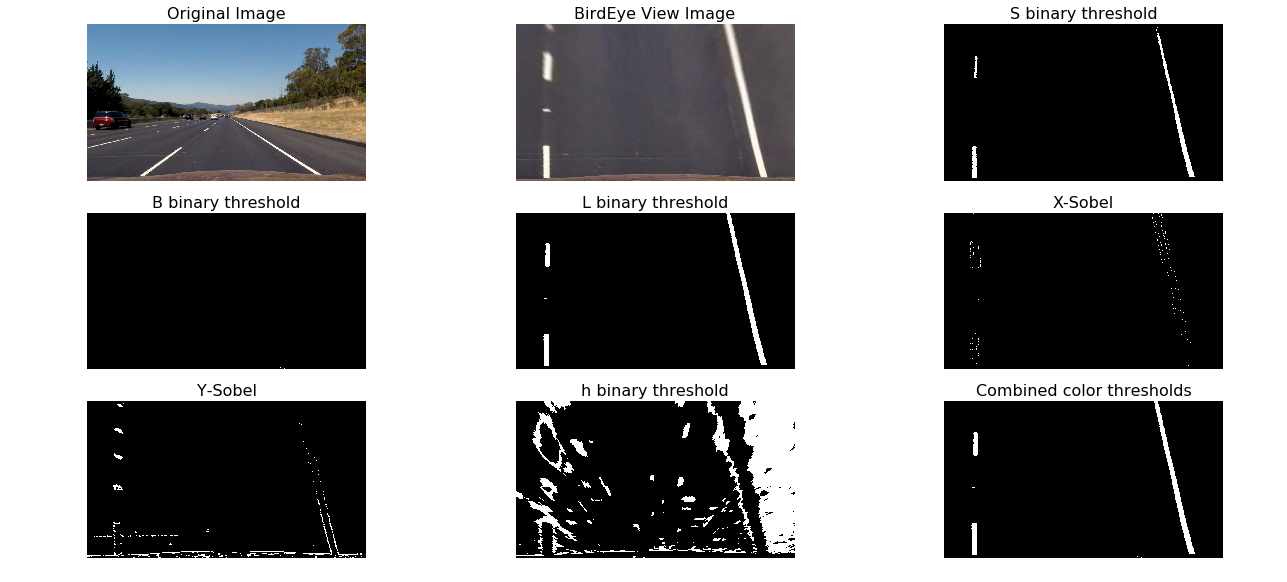

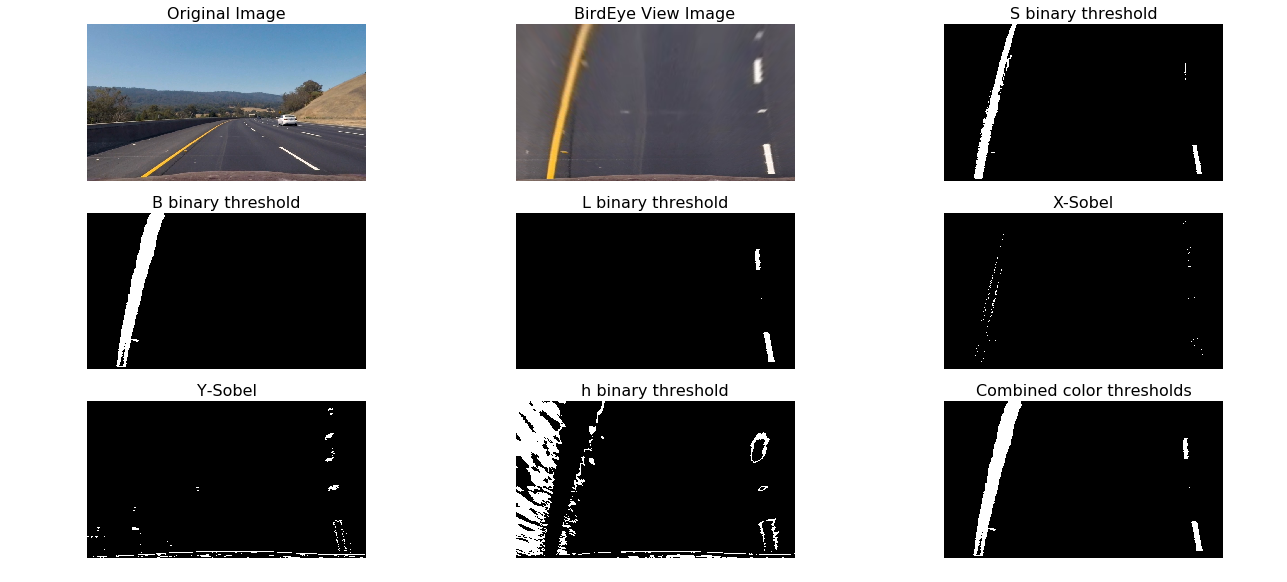

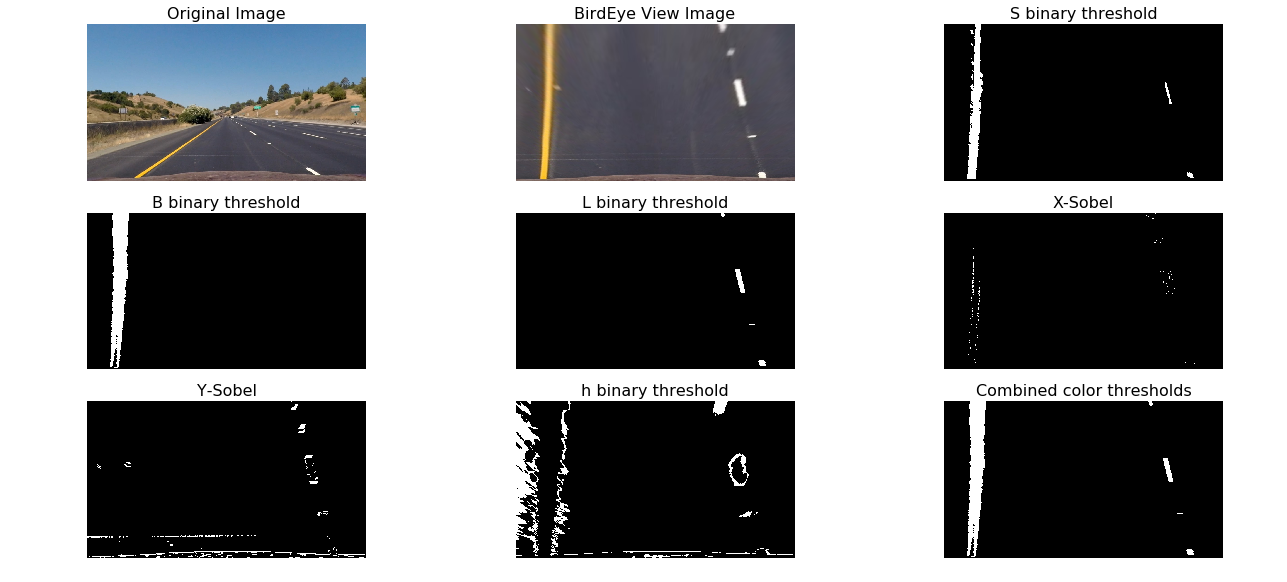

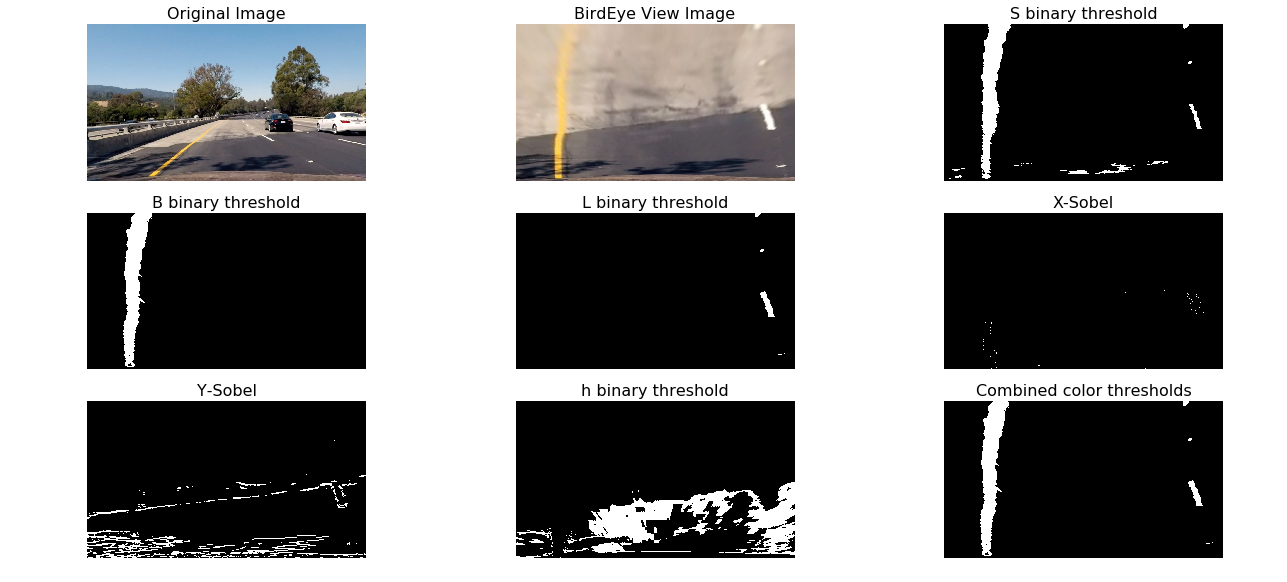

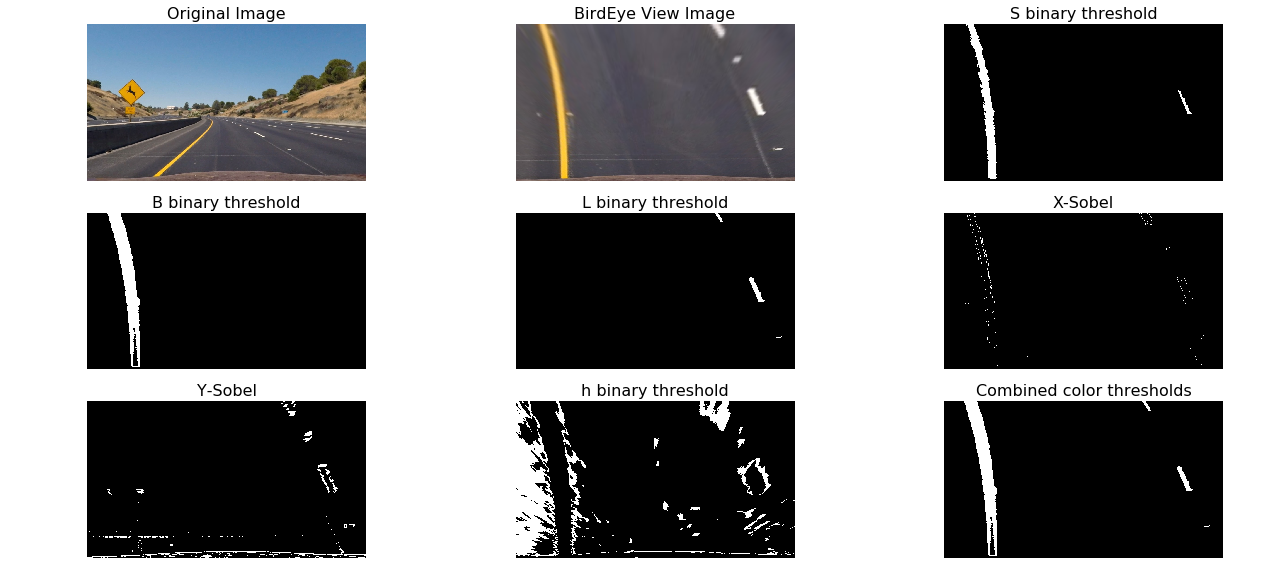

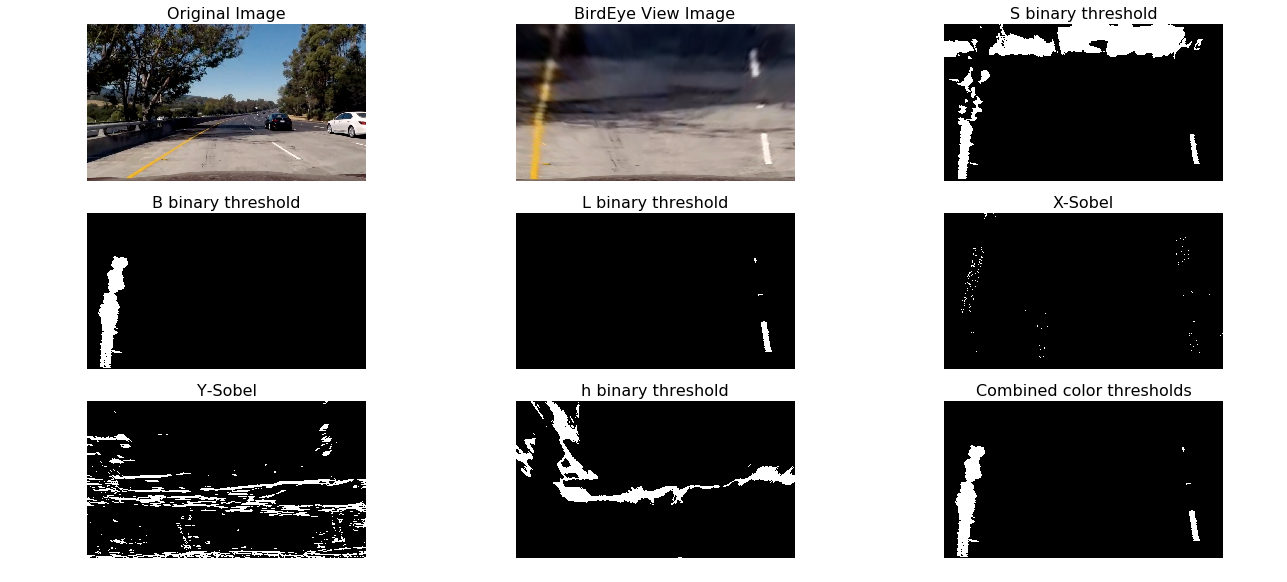

In [11]:
for image in glob.glob('test_images/*.jpg'):
    combine_color_binary(image)

### Steps 5 Find Lane Line. 
#### This step consist of multiples process. 5.1 to 5.5. 
First I want to show histogram of warped image below. The peak on histogram can be use as base to finding line.

In [12]:
def histvizual(image):
    #vizualised histogram of warped image
    #warpe_img = 'test_images/test3.jpg'
    image, M = birdseyeview(image)
    plt.figure(figsize=(8,5))
    plt.title('Undistorted and Warped Image', fontsize=20)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.savefig('output_images/histogram/test3.jpg')

    #Vizualised Histogram of image above
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    plt.figure(figsize=(8,4))
    plt.plot(histogram)
    plt.title('Histogram of Undistorted and Warped Image', fontsize=20)
    plt.show()
    #plt.savefig('output_images/histogram/histogram.jpg')

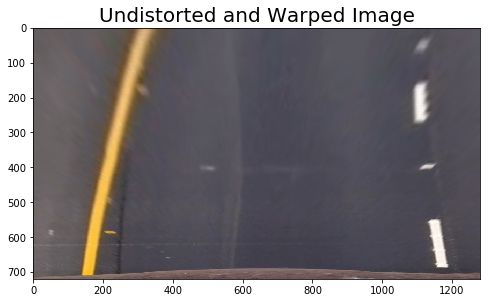

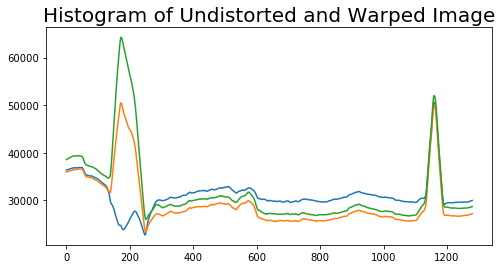

In [13]:
warpeimg = 'test_images/test3.jpg'
histvizual(warpeimg)

### 5.1 Detect lane pixels with histogram and fit to the lane boundary. 
With help from histogram on each images I deploy peak sliding windows search to detect maximum value on each left and rigth part of images.  

In [14]:
def sliding_windows_search(binary):
    
    #initialize parameter
    rx, ry, lx, ly = ([] for i in range(4))
    x, y = np.nonzero(np.transpose(binary))
    
    # Set the width of the windows +/- margin and search line offset +/- searchline.
    margin = 90
    searchline=25
    
    #image dimension
    dimy,dimx=(binary.shape[0],binary.shape[1])
    wincentroids=dimx//2
    #print(dimy,dimx)
    
    for n in range(dimy,0,-margin):
        
        histogram = np.sum(binary[n-margin:n,:], axis=0)
        
        # find max peak on left side of images
        lmax = np.argmax(histogram[:wincentroids])
        x_idc = np.where((((lmax - searchline) < x)&(x < (lmax + searchline))&((y > n-margin)&(y < n))))
        if np.sum(x[x_idc]) != 0:
            lx.extend(x[x_idc].tolist())
            ly.extend(y[x_idc].tolist())
            
        # find max peak on right side of images
        rmax = np.argmax(histogram[wincentroids:]) + wincentroids
        x_idc = np.where((((rmax - searchline) < x)&(x < (rmax + searchline))&((y > n-margin)&(y < n))))
        if np.sum(x[x_idc]) != 0:
            rx.extend(x[x_idc].tolist())
            ry.extend(y[x_idc].tolist())
    
    #Find fit on the left side of image using formula f(y)=Ay^2+By+C on each left x and y coordinate
    # we are fitting for f(y), rather than f(x).
    ly = np.array(ly).astype(np.float32)
    lx = np.array(lx).astype(np.float32)
    lfit = np.polyfit(ly, lx, 2)
    lfitx = lfit[0]*ly**2 + lfit[1]*ly + lfit[2]
    lxincept = lfit[0]*dimy**2 + lfit[1]*dimy + lfit[2]
    lx = np.append(lx, lxincept)
    ly = np.append(ly, dimy)
    lx = np.append(lx,lfit[0]*0**2 + lfit[1]*0 + lfit[2])
    ly = np.append(ly, 0)
    lx = lx[np.argsort(ly)]
    ly = ly[np.argsort(ly)]
    lfit = np.polyfit(ly, lx, 2)       
    lfitx = lfit[0]*ly**2 + lfit[1]*ly + lfit[2]
    
    #Find fit on the left side of image using formula f(y)=Ay^2+By+C on each right x and y coordinate
    ry = np.array(ry).astype(np.float32)
    rx = np.array(rx).astype(np.float32)
    rfit = np.polyfit(ry, rx, 2)
    rfitx = rfit[0]*ry**2 + rfit[1]*ry + rfit[2]
    rxincept = rfit[0]*dimy**2 + rfit[1]*dimy + rfit[2]
    rx = np.append(rx,rxincept)
    ry = np.append(ry, dimy)
    rx = np.append(rx,rfit[0]*0**2 + rfit[1]*0 + rfit[2])
    ry = np.append(ry, 0)
    rx = rx[np.argsort(ry)]
    ry = ry[np.argsort(ry)]
    rfit = np.polyfit(ry, rx, 2)
    rfitx = rfit[0]*ry**2 + rfit[1]*ry + rfit[2]

    return rx,lx,ry,ly,rfitx,lfitx

### 5.2 Calculate radius of curvature. 
This function is to calulate curvature on detected lines.

In [15]:
    #Initialize scaling meter per pixels in road. 
    ypix = 17.00 / 720.00 # Approx. 1.7 dashes long- 10 feet per dashs
    xpix = 3.70 / 1050.00 # Look at the bottom of ward image

In [16]:
def curvature(lx,ly,rx,ry):
    #RCurvatory from intmath.com https://www.intmath.com/applications-differentiation/8-radius-curvature.php
    
    lfitctr = np.polyfit(ly*ypix, lx*xpix, 2)
    rfitctr = np.polyfit(ry*ypix, rx*xpix, 2)
    
    #Radius of curvatory from class Rcurve=(1+(2Ay+B)^2)^3/2)/ 2A 
    lcurv = ((1 + (2*lfitctr[0]*np.max(ly)*ypix + lfitctr[1])**2)**1.5) /np.absolute(2*lfitctr[0])
    rcurv = ((1 + (2*rfitctr[0]*np.max(ly)*ypix + rfitctr[1])**2)**1.5) /np.absolute(2*rfitctr[0])
    
    #print('left_curve',lcurv)
    #print('right_curve',rcurv)
    return(lcurv,rcurv)

### 5.3 Calculate vehicle position

In [17]:
def vehicle_position(combined_binary, rxincept,lxincept,lfitx,ly,rfitx,ry):
    
    #xpix = 3.70 / 1000.00
    
    #Following adopted and taught at Udacity class room - Advance lane finding - Tips and Tricks for the Project
    Minv = cv2.getPerspectiveTransform(destimg, sourceimg)

    wnol = np.zeros_like(combined_binary).astype(np.uint8)
    clrwrap = np.dstack((wnol, wnol, wnol))
    
    # Casting x,y value into usable format for cv2.fillPoly()
    ptsl = np.array([np.flipud(np.transpose(np.vstack([lfitx, ly])))])
    ptsr = np.array([np.transpose(np.vstack([rfitx, ry]))])
    pts = np.hstack((ptsl, ptsr))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(clrwrap, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)  #color R,G,B
    cv2.fillPoly(clrwrap, np.int_([pts]), (0,255, 0)) #color R,G,B
    
    # Warp image back to original using MinV inverse perspective.
    unwarp = cv2.warpPerspective(clrwrap, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    
    # Combine the result back on original image
    out = cv2.addWeighted(mpimg.imread(image), 1, unwarp, 0.5, 0)
    
    center = abs(640 - ((rxincept+lxincept)/2))*xpix

    return out, unwarp, center

### 5.4 Detect a Line Lane

This funtion is to detect line line and adjust vehicle position with help from parameter or function above. 

In [18]:
def detecting_lane(image):
    
    #image dimension
    dimy,dimx=720,1280
    
    combined_binary = combine_color_binary(image,visualize=False)
    rx,lx,ry,ly,rfitx,lfitx= sliding_windows_search(combined_binary)

    lfit = np.polyfit(ly, lx, 2) 
    rfit = np.polyfit(ry, rx, 2)
    
    #A second order polynomial curve f(y)=Ay^2+By+C 
    rxincept = rfit[0]*dimy**2 + rfit[1]*dimy + rfit[2]
    lxincept = lfit[0]*dimy**2 + lfit[1]*dimy + lfit[2]
    
    lcurv, rcurv = curvature(lx,ly,rx,ry)
    out, unwarp, center = vehicle_position(combined_binary, rxincept,lxincept,lfitx,ly,rfitx,ry)
    #center = abs((dimx/2) - ((rxincept+lxincept)/2))
    #print('center',center)

    fixed, (axis1, axis2) = plt.subplots(1,2, figsize=(10, 4))
    fixed.tight_layout()
    axis1.imshow(cv2.cvtColor((birdseyeview(image)[0]), cv2.COLOR_BGR2RGB))
    axis1.set_xlim(0, dimx)
    axis1.set_ylim(0, dimy)
    axis1.plot(lfitx, ly, color='blue', linewidth=3)
    axis1.plot(rfitx, ry, color='blue', linewidth=3)
    axis1.set_title('Polynomial Lane', fontsize=16)
    axis1.invert_yaxis()
    axis2.imshow(out)
    axis2.set_title('Fit shaded polynomial', fontsize=16)
    plt.savefig('output_images/polynomial/' + image)

    if center < (dimx/2):
        axis2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center),
                 style='italic', color='white', fontsize=10)
    else:
        axis2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center),
                 style='italic', color='white', fontsize=10)
    axis2.text(200, 175, 'Radius of curvature is {}m'.format(int((lcurv + rcurv)/2)),
             style='italic', color='white', fontsize=10)


    return cv2.addWeighted(mpimg.imread(image), 1, unwarp, 0.5, 0)


### 5.5 Display of the lane boundaries, estimation of lane curvature and vehicle position.

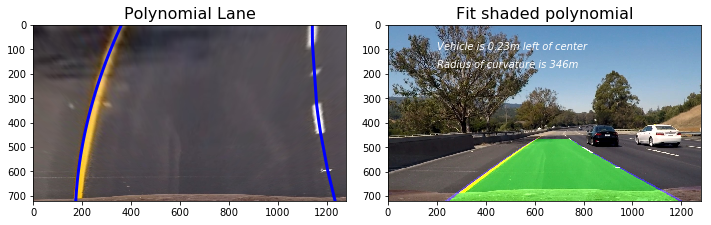

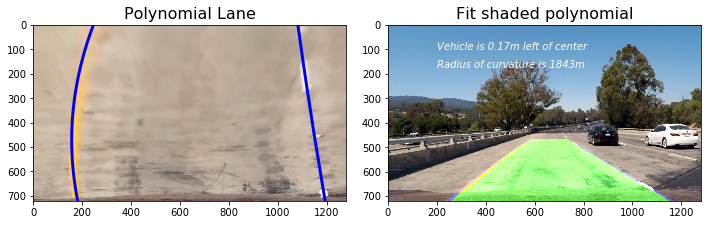

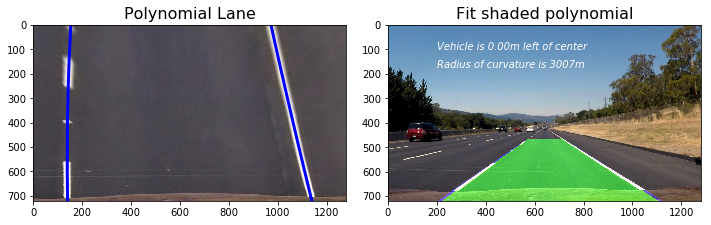

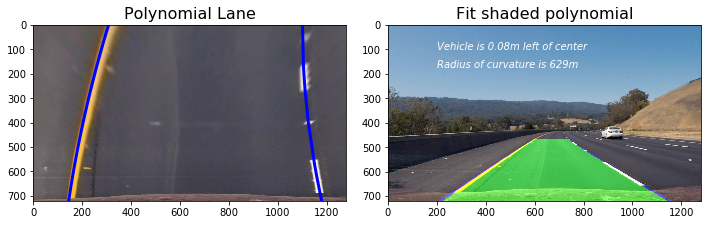

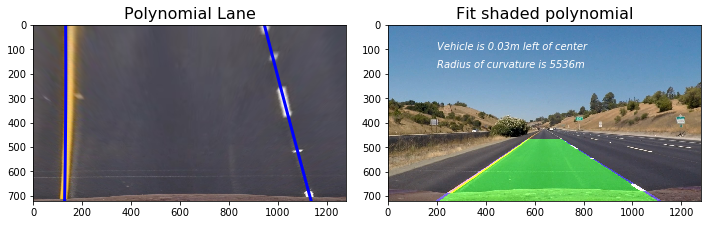

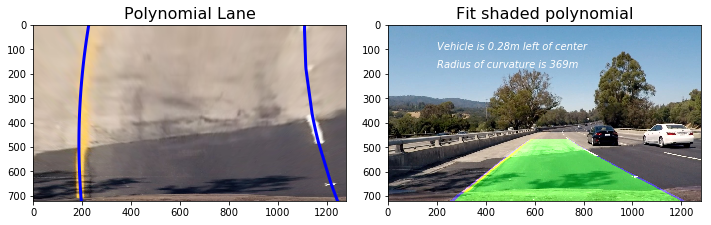

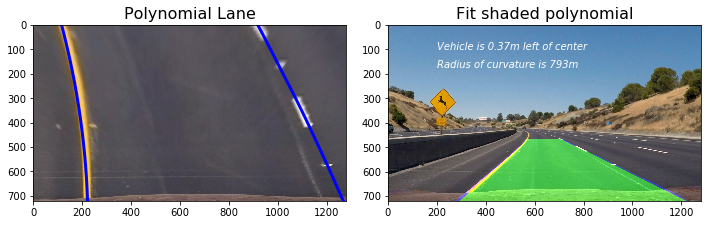

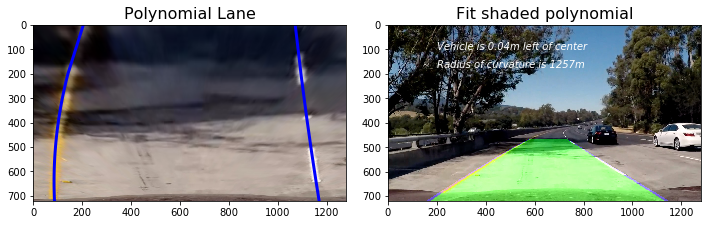

In [19]:
for image in glob.glob('test_images/*.jpg'):
    detecting_lane(image)

## Pipeline on Video Stream

In [20]:
class Line:
    def __init__(self):
        
        #initialize self.found
        self.found = False
        
        #initilize variables
        self.searchwidth=25
        self.margin=90
        self.offset=640
        self.ydim=720
        self.count = 0
        
        # x,y value of previous frame
        self.X = None
        self.Y = None
        
        # x intercept value use to average calculation
        self.xincept = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # previous x intercept value to compare
        self.lstxincept = None
        self.lstop = None
        
        # Radius of curvature initialization
        self.radius = None
        
        # Store recent coefficient. A Second order polynomial curve f(y)=Ay^2+By+C coefficient
        self.coefA = deque(maxlen=10)
        self.coefB = deque(maxlen=10)
        self.coefC = deque(maxlen=10)
        self.coefx = None
        self.pts = []
        
        # Initialize y meter per pixel parameter
        self.ypix = 17./720 # approx. 1.7 dashes long- 10 feet per dashs
        #self.ypix = None
        
        # Initialize x meter per pixel parameter
        self.xpix = 3.7/1050 
        #self.xpix = None 
        
    #calculate x and y when line found
    def locline(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            for n in range(self.ydim,0,-self.margin):
                yval = np.mean([n,n-self.margin])
                xval = (np.mean(self.coefA))*yval**2 + (np.mean(self.coefB))*yval + (np.mean(self.coefC))
                x_idx = np.where((((xval - self.searchwidth) < x)&(x < (xval + self.searchwidth))& \
                                  ((y > n-self.margin) & (y < n))))
                if np.sum(x[x_idx]) != 0:
                    np.append(xvals, x[x_idx])
                    np.append(yvals, y[x_idx])
        if np.sum(xvals) == 0: 
            self.found = False 
        return xvals, yvals, self.found
    
    #Run windows search when line is missing
    def findline(self, x, y, image):
        x_axis = []
        y_axis = []
        if self.found == False: 
            for n in range(self.ydim,0,-self.margin):
                histogram = np.sum(image[n-self.margin:n,:], axis=0)
                if self == Rline:
                    peak = np.argmax(histogram[self.offset:]) + self.offset
                else:
                    peak = np.argmax(histogram[:self.offset])
                x_idx = np.where((((peak - self.searchwidth) < x)&(x < (peak + self.searchwidth))& \
                                  ((y > n-self.margin) & (y < n))))
                if np.sum(x[x_idx]) != 0:
                    x_axis.extend(x[x_idx])
                    y_axis.extend(y[x_idx])
        if np.sum(x_axis) > 0:
            self.found = True
        else:
            y_axis = self.Y
            x_axis = self.X
        return x_axis, y_axis, self.found
    
    #measure curve radius
    def radcurv(self, xvals, yvals):
        #ypix = 10./720 declare as self.ypix
        #xpix = 3.7/1000 declare as self.xpix
        fit_cr = np.polyfit(yvals*self.ypix, xvals*self.xpix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals)*self.ypix + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
     
        return curverad
        #return lcurv, rcurv
        
    def shtnum(self, xnum, ynum):
        shtidc = np.argsort(ynum)
        yshtnum = ynum[shtidc]
        xshtnum = xnum[shtidc]
        return xshtnum, yshtnum
    
    #measure intercept
    def incept(self, polynomial):
        bottom = polynomial[0]*self.ydim**2 + polynomial[1]*self.ydim + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [21]:
# Video processing pipeline define here
def videopipeline(image):
    #Initililize radius curvature
    adcuravg = None
   
    img_size = (image.shape[1], image.shape[0])
    
    dimy,dimx=(image.shape[0],image.shape[1])
    
    # Apply image undistort function 
    undist=undistort(image,videoprocess=True)
    
    # Apply image warp process
    M = cv2.getPerspectiveTransform(sourceimg, destimg)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Apply binary image threshold
    x_colospace_thresh = colospace_thresh(warped, orient='x', thresh_min=45, thresh_max=50)
    b_binary = colospace_thresh(warped, orient='brgb', thresh_min=147, thresh_max=200) #148
    l_binary = colospace_thresh(warped, orient='lrgb', thresh_min=217, thresh_max=255)
    
   
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Check for non zero value on binary threshol image
    x, y = np.nonzero(np.transpose(combined_binary)) 
    
    #Initialize parameters
    rx, ry, lx, ly = ([] for i in range(4))
    
    #print('Lline.found',Lline.found)
    #print('Rline.found',Rline.found)
    
    # Check for pixels then feed to Line class (if found). Otherwise perform blind search to image using (def find line)
    # on Line class.
    if Lline.found == True: 
        lx, ly, Lline.found = Lline.locline(x, y)
    if Lline.found == False:
        lx, ly, Lline.found = Lline.findline(x, y, combined_binary)
    if Rline.found == True:
        rx, ry, Rline.found = Rline.locline(x, y)
    if Rline.found == False: 
        rx, ry, Rline.found = Rline.findline(x, y, combined_binary)      

    #Casting arrays to float32
    ly = np.array(ly).astype(np.float32)
    lx = np.array(lx).astype(np.float32)
    ry = np.array(ry).astype(np.float32)
    rx = np.array(rx).astype(np.float32)
        
    # Calculate left polynomial fit based on detected pixels
    lfit = np.polyfit(ly, lx, 2)
    
    # Left - Lane ; Find and calculate intercept from top to bottom 
    lxincept, ltop = Lline.incept(lfit)
    
    # Calculate average on numbers of frame
    Lline.xincept.append(lxincept)
    Lline.top.append(ltop)
    lxincept = np.mean(Lline.xincept)
    ltop = np.mean(Lline.top)
    Lline.lstxincept = lxincept
    Lline.lstop = ltop
    
    # Append intercept value
    lx = np.append(lx, lxincept)
    ly = np.append(ly, dimy)
    lx = np.append(lx, ltop)
    ly = np.append(ly, 0)
        
    # Left Sort right lane pixels
    lx, ly = Lline.shtnum(lx, ly)
    Lline.X = lx
    Lline.Y = ly
      
    # calculation for average and intercept
    lfit = np.polyfit(ly, lx, 2)
    Lline.coefA.append(lfit[0])
    Lline.coefB.append(lfit[1])
    Lline.coefC.append(lfit[2])
    lfit = [np.mean(Lline.coefA),np.mean(Lline.coefB),np.mean(Lline.coefC)]
    
    # Fit polynomial line to detected pixels
    lfitx = lfit[0]*ly**2 + lfit[1]*ly + lfit[2]
    Lline.coefx = lfitx
    
    # Calculate right polynomial fit based on detected pixels
    rfit = np.polyfit(ry, rx, 2)

    # Find and calculate intercept from top to bottom
    rxincept, rtop = Rline.incept(rfit)
    
    # Calculate average on numbers of frame
    Rline.xincept.append(rxincept)
    rxincept = np.mean(Rline.xincept)
    Rline.top.append(rtop)
    rtop = np.mean(Rline.top)
    Rline.lstxincept = rxincept
    Rline.lstop = rtop
    rx = np.append(rx, rxincept)
    ry = np.append(ry, dimy)
    rx = np.append(rx, rtop)
    ry = np.append(ry, 0)
    
    # Sort right lane pixels
    rx, ry = Rline.shtnum(rx, ry)
    Rline.X = rx
    Rline.Y = ry
    
    # Recalculate polynomial with intercepts and average on all frames
    rfit = np.polyfit(ry, rx, 2)
    Rline.coefA.append(rfit[0])
    Rline.coefB.append(rfit[1])
    Rline.coefC.append(rfit[2])
    rfit = [np.mean(Rline.coefA), np.mean(Rline.coefB), np.mean(Rline.coefC)]
    
    # Fit polynomial to detected pixels
    rfitx = rfit[0]*ry**2 + rfit[1]*ry + rfit[2]
    Rline.coefx = rfitx
        
    #Print out curvatory
    if adcuravg is None:
        adcuravg = int(Lline.radcurv(lx, ly)+Rline.radcurv(rx, ry))/2
    elif len(lx) != 0 and len(rx) != 0: 
        adcuravg = int(Lline.radcurv(lx, ly)+Rline.radcurv(rx, ry))/2
    
    #print('Left curvatory',Lline.radcurv(lx, ly))
    #print('Right curvatory',Rline.radcurv(rx, ry))
    #print('curvatory',adcuravg)
     
    # Calculate the vehicle position
    vehic_pos = abs((dimx/2 - (rxincept+lxincept)/2)*xpix)  
                
    Minv = cv2.getPerspectiveTransform(destimg, sourceimg)
    
    # Initialize an image to draw
    wnol = np.zeros_like(combined_binary).astype(np.uint8)
    clrwpr = np.dstack((wnol, wnol, wnol))
    
    # Cast x,y ready for cv2.fillPoly()
    lpts = np.array([np.flipud(np.transpose(np.vstack([Lline.coefx, Lline.Y])))])
    rpts = np.array([np.transpose(np.vstack([rfitx, Rline.Y]))])
    pts = np.hstack((lpts, rpts))
    cv2.polylines(clrwpr, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    
    # Draw the lane on warped blank image
    cv2.fillPoly(clrwpr, np.int_(pts), (0,255,0))
    
    #Utilized inverse perspective matrix MinV to wapr back to original
    unwarp = cv2.warpPerspective(clrwpr, Minv, (image.shape[1], image.shape[0]))
    
    #Combined with original image
    out = cv2.addWeighted(undist, 1, unwarp, 0.4, 0)
        
    # Print distance from center on video
    if vehic_pos > dimx/2: 
        cv2.putText(out, 'Vehicle is {:.2f}m left of center'.format(vehic_pos), (102,81),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(out, 'Vehicle is {:.2f}m right of center'.format(vehic_pos), (102,81),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)

    # Print radius of curvature on video
    cv2.putText(out, 'Radius of Curvature {}(m)'.format(adcuravg), (102,141),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2)
    #Lline.count += 1
    
    return out

In [22]:
Lline = Line()
Rline = Line()
video_output = 'output_videos/project_video_result.mp4'
video_output = 'result.mp4'
vid1 = VideoFileClip("project_video.mp4").subclip(0,50) #0,50 full video
outvid = vid1.fl_image(videopipeline) 
outvid.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1250/1251 [07:43<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [23]:
Lline = Line()
Rline = Line()
video_output = 'output_videos/challenge_video_result.mp4'
vid1 = VideoFileClip("challenge_video.mp4").subclip(0,16) #0,16  full video
outvid = vid1.fl_image(videopipeline) 
outvid.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_result.mp4
[MoviePy] Writing video output_videos/challenge_video_result.mp4


100%|██████████| 480/480 [02:06<00:00,  3.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_result.mp4 



In [24]:
Lline = Line()
Rline = Line()
video_output = 'output_videos/harder_video_result.mp4'
vid1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,47) #0,47  full video
outvid = vid1.fl_image(videopipeline) 
outvid.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_video_result.mp4
[MoviePy] Writing video output_videos/harder_video_result.mp4


100%|█████████▉| 1175/1176 [08:21<00:00,  2.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_video_result.mp4 

